<a href="https://colab.research.google.com/github/RamishMohammad/Capstone/blob/main/color_model_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/Example2

Streaming output truncated to the last 5000 lines.
  inflating: Example2/train/trainB/3076.png  
  inflating: __MACOSX/Example2/train/trainB/._3076.png  
  inflating: Example2/train/trainB/1107.png  
  inflating: __MACOSX/Example2/train/trainB/._1107.png  
  inflating: Example2/train/trainB/3704.png  
  inflating: __MACOSX/Example2/train/trainB/._3704.png  
  inflating: Example2/train/trainB/3062.png  
  inflating: __MACOSX/Example2/train/trainB/._3062.png  
  inflating: Example2/train/trainB/2195.png  
  inflating: __MACOSX/Example2/train/trainB/._2195.png  
  inflating: Example2/train/trainB/652.png  
  inflating: __MACOSX/Example2/train/trainB/._652.png  
  inflating: Example2/train/trainB/2803.png  
  inflating: __MACOSX/Example2/train/trainB/._2803.png  
  inflating: Example2/train/trainB/875.png  
  inflating: __MACOSX/Example2/train/trainB/._875.png  
  inflating: Example2/train/trainB/21.png  
  inflating: __MACOSX/Example2/train/trainB/._21.png  
  inflating: Example2/train/tr

In [ ]:
from PIL import Image
import os
from torch.utils.data import Dataset
import numpy as np

class HorseZebraDataset(Dataset):
    def __init__(self, root_zebra, root_horse, transform=None):
        self.root_zebra = root_zebra
        self.root_horse = root_horse
        self.transform = transform

        self.zebra_images = os.listdir(root_zebra)
        self.horse_images = os.listdir(root_horse)
        self.length_dataset = max(len(self.zebra_images), len(self.horse_images)) # 1000, 1500
        self.zebra_len = len(self.zebra_images)
        self.horse_len = len(self.horse_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        zebra_img = self.zebra_images[index % self.zebra_len]
        horse_img = self.horse_images[index % self.horse_len]

        zebra_path = os.path.join(self.root_zebra, zebra_img)
        horse_path = os.path.join(self.root_horse, horse_img)

        zebra_img = np.array(Image.open(zebra_path).convert("RGB"))
        horse_img = np.array(Image.open(horse_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=zebra_img, image0=horse_img)
            zebra_img = augmentations["image"]
            horse_img = augmentations["image0"]

        return zebra_img, horse_img

In [ ]:
import torch
import torch.nn as nn


class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                4,
                stride,
                1,
                bias=True,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                Block(in_channels, feature, stride=1 if feature == features[-1] else 2)
            )
            in_channels = feature
        layers.append(
            nn.Conv2d(
                in_channels,
                1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            )
        )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))


def test():
    x = torch.randn((5, 3, 256, 256))
    model = Discriminator(in_channels=3)
    preds = model(x)
    print(preds.shape)


if __name__ == "__main__":
    test()

torch.Size([5, 1, 30, 30])


In [ ]:
import torch
import torch.nn as nn


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity(),
        )

    def forward(self, x):
        return self.conv(x)


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(
                    num_features, num_features * 2, kernel_size=3, stride=2, padding=1
                ),
                ConvBlock(
                    num_features * 2,
                    num_features * 4,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(
                    num_features * 4,
                    num_features * 2,
                    down=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvBlock(
                    num_features * 2,
                    num_features * 1,
                    down=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))


def test():
    img_channels = 3
    img_size = 256
    x = torch.randn((2, img_channels, img_size, img_size))
    gen = Generator(img_channels, 9)
    print(gen(x).shape)


if __name__ == "__main__":
    test()

torch.Size([2, 3, 256, 256])


In [ ]:
import random, torch, os, numpy as np
import torch.nn as nn
import copy

def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



In [ ]:
!pip install numba
from numba import cuda
# all of your code and execution
cuda.select_device(0)
cuda.close()

In [ ]:
import torch
import sys
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision.utils import save_image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np
import os

# Define empty lists to store losses
train_losses = []
val_losses = []

# Configuration settings
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "data/train"
VAL_DIR = "data/val"
BATCH_SIZE = 20
LEARNING_RATE = 3e-5
LAMBDA_IDENTITY = 0.5    #0.0
LAMBDA_CYCLE = 10          #3
NUM_WORKERS = 5
NUM_EPOCHS = 10
LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_GEN_H = "/content/saved_checkpoints/gen_H.pth"
CHECKPOINT_GEN_Z = "/content/saved_checkpoints/gen_Z.pth"
CHECKPOINT_CRITIC_H = "/content/saved_checkpoints/disc_H.pth"
CHECKPOINT_CRITIC_Z = "/content/saved_checkpoints/disc_Z.pth"

# Define transforms
transforms = A.Compose([
    A.Resize(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.2),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
    ToTensorV2(),
], additional_targets={"image0": "image"}, is_check_shapes=False)

# Training function
def train_fn(disc_H, disc_Z, gen_Z, gen_H, train_loader, val_loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler):
    loop = tqdm(train_loader, leave=True)
    H_reals = 0
    H_fakes = 0
    epoch_train_losses = []

    for idx, (zebra, horse) in enumerate(loop):
        zebra = zebra.to(DEVICE)
        horse = horse.to(DEVICE)

        # Train Discriminators H and Z
        with torch.cuda.amp.autocast():
            fake_horse = gen_H(zebra)
            D_H_real = disc_H(horse)
            D_H_fake = disc_H(fake_horse.detach())
            H_reals += D_H_real.mean().item()
            H_fakes += D_H_fake.mean().item()
            D_H_real_loss = mse(D_H_real, torch.ones_like(D_H_real))
            D_H_fake_loss = mse(D_H_fake, torch.zeros_like(D_H_fake))
            D_H_loss = D_H_real_loss + D_H_fake_loss

            fake_zebra = gen_Z(horse)
            D_Z_real = disc_Z(zebra)
            D_Z_fake = disc_Z(fake_zebra.detach())
            D_Z_real_loss = mse(D_Z_real, torch.ones_like(D_Z_real))
            D_Z_fake_loss = mse(D_Z_fake, torch.zeros_like(D_Z_fake))
            D_Z_loss = D_Z_real_loss + D_Z_fake_loss

            D_loss = (D_H_loss + D_Z_loss) / 2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train Generators H and Z
        with torch.cuda.amp.autocast():
            D_H_fake = disc_H(fake_horse)
            D_Z_fake = disc_Z(fake_zebra)
            loss_G_H = mse(D_H_fake, torch.ones_like(D_H_fake))
            loss_G_Z = mse(D_Z_fake, torch.ones_like(D_Z_fake))

            cycle_zebra = gen_Z(fake_horse)
            cycle_horse = gen_H(fake_zebra)
            cycle_zebra_loss = l1(zebra, cycle_zebra)
            cycle_horse_loss = l1(horse, cycle_horse)

            identity_zebra = gen_Z(zebra)
            identity_horse = gen_H(horse)
            identity_zebra_loss = l1(zebra, identity_zebra)
            identity_horse_loss = l1(horse, identity_horse)

            G_loss = (
                loss_G_Z + loss_G_H + cycle_zebra_loss * LAMBDA_CYCLE +
                cycle_horse_loss * LAMBDA_CYCLE +
                identity_horse_loss * LAMBDA_IDENTITY +
                identity_zebra_loss * LAMBDA_IDENTITY
            )

        epoch_train_losses.append((D_loss.item(), G_loss.item()))

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 200 == 0:
            with torch.no_grad():
                for i in range(fake_horse.shape[0]):
                    save_image(fake_horse[i:i+1] * 0.5 + 0.5, f"saved_images/horse_{idx}_{i}.png")
                    save_image(fake_zebra[i:i+1] * 0.5 + 0.5, f"saved_images/zebra_{idx}_{i}.png")

        loop.set_postfix(H_real=H_reals / (idx + 1), H_fake=H_fakes / (idx + 1))
        torch.cuda.empty_cache()

    # Calculate validation loss
    val_loss = calculate_val_loss(disc_H, disc_Z, gen_Z, gen_H, val_loader, l1, mse)
    val_losses.append(val_loss)

    # Calculate average training loss for the epoch
    epoch_train_loss_avg = tuple(np.mean(epoch_train_losses, axis=0))
    train_losses.append(epoch_train_loss_avg)

    # Append average training loss for the epoch
    epoch_train_loss_avg = tuple(np.mean(epoch_train_losses, axis=0))
    train_losses.append(epoch_train_loss_avg)



def calculate_val_loss(disc_H, disc_Z, gen_Z, gen_H, val_loader, l1, mse):
    val_loss = 0.0
    num_batches = 0

    for zebra, horse in val_loader:
        zebra = zebra.to(DEVICE)
        horse = horse.to(DEVICE)

        with torch.no_grad():
            # Validation loss calculation
            fake_horse = gen_H(zebra)
            D_H_real = disc_H(horse)
            D_H_fake = disc_H(fake_horse.detach())
            D_H_real_loss = mse(D_H_real, torch.ones_like(D_H_real))
            D_H_fake_loss = mse(D_H_fake, torch.zeros_like(D_H_fake))
            D_H_loss = D_H_real_loss + D_H_fake_loss

            fake_zebra = gen_Z(horse)
            D_Z_real = disc_Z(zebra)
            D_Z_fake = disc_Z(fake_zebra.detach())
            D_Z_real_loss = mse(D_Z_real, torch.ones_like(D_Z_real))
            D_Z_fake_loss = mse(D_Z_fake, torch.zeros_like(D_Z_fake))
            D_Z_loss = D_Z_real_loss + D_Z_fake_loss

            D_loss = (D_H_loss + D_Z_loss) / 2

            loss_G_H = mse(D_H_fake, torch.ones_like(D_H_fake))
            loss_G_Z = mse(D_Z_fake, torch.ones_like(D_Z_fake))

            cycle_zebra = gen_Z(fake_horse)
            cycle_horse = gen_H(fake_zebra)
            cycle_zebra_loss = l1(zebra, cycle_zebra)
            cycle_horse_loss = l1(horse, cycle_horse)

            identity_zebra = gen_Z(zebra)
            identity_horse = gen_H(horse)
            identity_zebra_loss = l1(zebra, identity_zebra)
            identity_horse_loss = l1(horse, identity_horse)

            G_loss = (
                loss_G_Z + loss_G_H + cycle_zebra_loss * LAMBDA_CYCLE +
                cycle_horse_loss * LAMBDA_CYCLE +
                identity_horse_loss * LAMBDA_IDENTITY +
                identity_zebra_loss * LAMBDA_IDENTITY
            )

            val_loss += G_loss.item()
            num_batches += 1

    # Calculate average validation loss
    val_loss /= num_batches
    return val_loss


# Main function
def main():
    disc_H = Discriminator(in_channels=3).to(DEVICE)
    disc_Z = Discriminator(in_channels=3).to(DEVICE)
    gen_Z = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    gen_H = Generator(img_channels=3, num_residuals=9).to(DEVICE)

    opt_disc = optim.Adam(
        list(disc_H.parameters()) + list(disc_Z.parameters()),
        lr=LEARNING_RATE, betas=(0.5, 0.999)
    )
    opt_gen = optim.Adam(
        list(gen_Z.parameters()) + list(gen_H.parameters()),
        lr=LEARNING_RATE, betas=(0.5, 0.999)
    )

    L1 = nn.L1Loss()
    mse = nn.MSELoss()

    if LOAD_MODEL:
      load_checkpoint(
          CHECKPOINT_GEN_H,
          gen_H,
          opt_gen,
          LEARNING_RATE,
      )
      load_checkpoint(
          CHECKPOINT_GEN_Z,
          gen_Z,
          opt_gen,
          LEARNING_RATE,
      )
      load_checkpoint(
          CHECKPOINT_CRITIC_H,
          disc_H,
          opt_disc,
          LEARNING_RATE,
      )
      load_checkpoint(
          CHECKPOINT_CRITIC_Z,
          disc_Z,
          opt_disc,
          LEARNING_RATE,
      )

    dataset = HorseZebraDataset(
        root_horse=os.path.join(TRAIN_DIR, "trainA"),
        root_zebra=os.path.join(TRAIN_DIR, "trainA"),
        transform=transforms
    )
    val_dataset = HorseZebraDataset(
        root_horse=os.path.join(VAL_DIR, "testA"),
        root_zebra=os.path.join(VAL_DIR, "testA"),
        transform=transforms
    )

    val_loader = DataLoader(
        val_dataset, batch_size=1, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=True
    )
    loader = DataLoader(
        dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=NUM_WORKERS, pin_memory=True
    )

    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    checkpoint_dir = "saved_checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_gen_H_path = os.path.join(checkpoint_dir, "gen_H.pth")
    checkpoint_gen_Z_path = os.path.join(checkpoint_dir, "gen_Z.pth")
    checkpoint_disc_H_path = os.path.join(checkpoint_dir, "disc_H.pth")
    checkpoint_disc_Z_path = os.path.join(checkpoint_dir, "disc_Z.pth")


    for epoch in range(NUM_EPOCHS):
        train_fn(
            disc_H, disc_Z, gen_Z, gen_H, loader, val_loader, opt_disc, opt_gen,
            L1, mse, d_scaler, g_scaler
        )

        torch.cuda.empty_cache()

        if SAVE_MODEL:
            save_checkpoint(gen_H, opt_gen, filename=checkpoint_gen_H_path)
            save_checkpoint(gen_Z, opt_gen, filename=checkpoint_gen_Z_path)
            save_checkpoint(disc_H, opt_disc, filename=checkpoint_disc_H_path)
            save_checkpoint(disc_Z, opt_disc, filename=checkpoint_disc_Z_path)

    # Plot the losses
    plot_losses(train_losses, val_losses)

def plot_losses(train_losses, val_losses):
    print("train_losses:", train_losses)
    print("val_losses:", val_losses)

    # Ensure the lengths of train_losses and val_losses are the same
    min_length = min(len(train_losses), len(val_losses))
    train_losses = train_losses[:min_length]
    val_losses = val_losses[:min_length]

    # Plot both training and validation losses
    plt.figure(figsize=(10, 5))
    epochs = range(1, min_length + 1)
    plt.plot(epochs, [loss[1] for loss in train_losses], label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()



if __name__ == "__main__":
    main()



=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint


  0%|          | 0/70 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:453: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
  0%|          | 0/70 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 40.00 MiB. GPU 

In [ ]:
!unzip /content/apple2orange_A

Archive:  /content/apple2orange_A.zip
   creating: apple2orange_A copy/
  inflating: __MACOSX/._apple2orange_A copy  
  inflating: apple2orange_A copy/.DS_Store  
  inflating: __MACOSX/apple2orange_A copy/._.DS_Store  
   creating: apple2orange_A copy/content/
  inflating: __MACOSX/apple2orange_A copy/._content  
  inflating: apple2orange_A copy/content/.DS_Store  
  inflating: __MACOSX/apple2orange_A copy/content/._.DS_Store  
   creating: apple2orange_A copy/content/samples/
  inflating: __MACOSX/apple2orange_A copy/content/._samples  
  inflating: apple2orange_A copy/content/samples/.DS_Store  
  inflating: __MACOSX/apple2orange_A copy/content/samples/._.DS_Store  
   creating: apple2orange_A copy/content/samples/CycleGAN-apple2orange/
  inflating: __MACOSX/apple2orange_A copy/content/samples/._CycleGAN-apple2orange  
  inflating: apple2orange_A copy/content/samples/CycleGAN-apple2orange/.DS_Store  
  inflating: __MACOSX/apple2orange_A copy/content/samples/CycleGAN-apple2orange/._.D

In [ ]:
!unzip /content/saved_checkpoints

Archive:  /content/saved_checkpoints.zip
warning [/content/saved_checkpoints.zip]:  343065396 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  343065396
  (attempting to re-compensate)
   creating: content/saved_checkpoints/
error: invalid zip file with overlapped components (possible zip bomb)


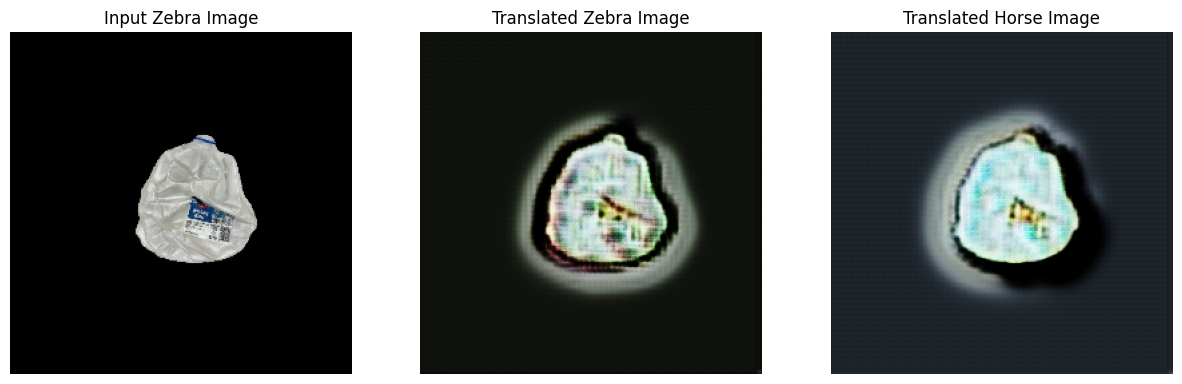

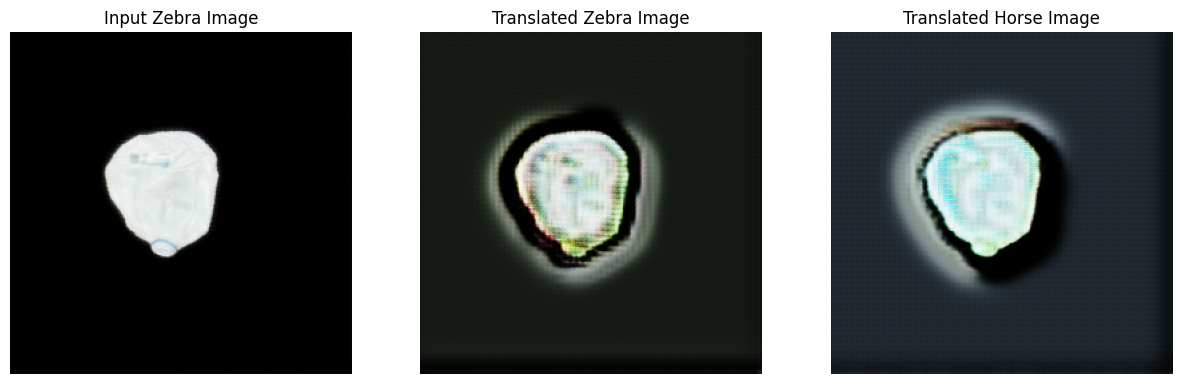

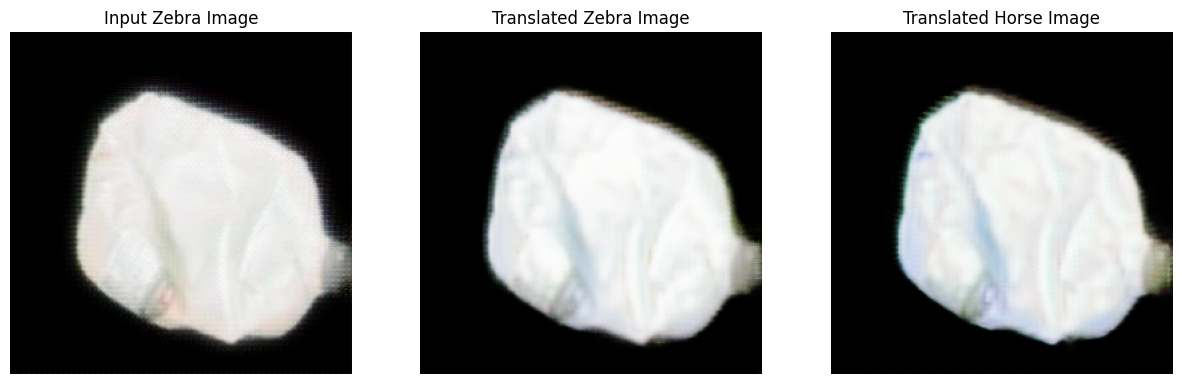

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define the transform pipeline using albumentations
transform = A.Compose([
    A.Resize(width=256, height=256),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
    ToTensorV2()
])

class AlbumentationsDataset(ImageFolder):
    def __getitem__(self, idx):
        image, label = super().__getitem__(idx)
        image = np.array(image)
        transformed = transform(image=image)
        return transformed["image"], label

# Assuming 'testA' is the path to your dataset
testA_dataset = AlbumentationsDataset(root='/content/apple2orange_A copy/content/samples/CycleGAN-apple2orange')

# Define batch size
batch_size = 1

# Define DataLoader
loader = DataLoader(testA_dataset, batch_size=batch_size, shuffle=True)

# Define paths for saved checkpoints
checkpoint_gen_H_path = "/content/saved_checkpoints/gen_H.pth"
checkpoint_gen_Z_path = "/content/saved_checkpoints/gen_Z.pth"

# Load the checkpoints
checkpoint_gen_H = torch.load(checkpoint_gen_H_path)
gen_H = Generator(img_channels=3, num_residuals=9).to(DEVICE)
gen_H.load_state_dict(checkpoint_gen_H['state_dict'])

checkpoint_gen_Z = torch.load(checkpoint_gen_Z_path)
gen_Z = Generator(img_channels=3, num_residuals=9).to(DEVICE)
gen_Z.load_state_dict(checkpoint_gen_Z['state_dict'])

# Ensure that both models are in evaluation mode after loading
gen_H.eval()
gen_Z.eval()

# Denormalization function to convert the outputs back to [0, 1] range for visualization
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5
    return tensor.clamp(0, 1)

# Create directories for saving the images
output_dir_horse = '/content/img/translated_horse'
output_dir_zebra = '/content/img/translated_zebra'
os.makedirs(output_dir_horse, exist_ok=True)
os.makedirs(output_dir_zebra, exist_ok=True)

# Iterate over your dataset and apply the models for inference
for idx, (zebra, _) in enumerate(loader):
    zebra = zebra.to(DEVICE)

    # Translate images
    with torch.no_grad():
        translated_horse = gen_H(zebra).cpu()
        translated_zebra = gen_Z(zebra).cpu()

    # Denormalize images
    translated_horse = denormalize(translated_horse)
    translated_zebra = denormalize(translated_zebra)
    input_zebra = denormalize(zebra.cpu())

    # Convert tensors to PIL images
    translated_horse_pil = to_pil_image(translated_horse[0])
    translated_zebra_pil = to_pil_image(translated_zebra[0])
    input_zebra_pil = to_pil_image(input_zebra[0])

    # Save the images
    translated_horse_pil.save(os.path.join(output_dir_horse, f'translated_horse_{idx}.png'))
    translated_zebra_pil.save(os.path.join(output_dir_zebra, f'translated_zebra_{idx}.png'))

    # Optionally, display input and translated images side by side for comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(input_zebra_pil)
    axes[0].set_title("Input Zebra Image")
    axes[0].axis('off')
    axes[1].imshow(translated_zebra_pil)
    axes[1].set_title("Translated Zebra Image")
    axes[1].axis('off')
    axes[2].imshow(translated_horse_pil)
    axes[2].set_title("Translated Horse Image")
    axes[2].axis('off')
    plt.show()


In [ ]:
!zip -r /content/saved_checkpoints-New.zip /content/saved_checkpoints

  adding: content/saved_checkpoints/ (stored 0%)
  adding: content/saved_checkpoints/disc_H.pth (deflated 8%)
  adding: content/saved_checkpoints/gen_H.pth (deflated 8%)
  adding: content/saved_checkpoints/gen_Z.pth (deflated 8%)
  adding: content/saved_checkpoints/disc_Z.pth (deflated 8%)


In [ ]:
from google.colab import files
files.download("/content/cyclegan_imgs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch
import sys

torch.cuda.empty_cache()
# Set memory growth configuration
PYTORCH_CUDA_ALLOC_CONF = "expandable_segments:True"
sys.modules["torch.cuda"].CUDA_LAUNCH_BLOCKING = "1"


from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision.utils import save_image
import albumentations as A
from albumentations.pytorch import ToTensorV2



# Configuration settings copied from config.py
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "data/train"
VAL_DIR = "data/val"
BATCH_SIZE = 10
LEARNING_RATE = 1e-5
LAMBDA_IDENTITY = 0.0
LAMBDA_CYCLE = 10
NUM_WORKERS = 4
NUM_EPOCHS = 1
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_GEN_H = "genh.pth.tar"
CHECKPOINT_GEN_Z = "genz.pth.tar"
CHECKPOINT_CRITIC_H = "critich.pth.tar"
CHECKPOINT_CRITIC_Z = "criticz.pth.tar"

transforms = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    additional_targets={"image0": "image"},
)


def train_fn(
    disc_H, disc_Z, gen_Z, gen_H, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler
):
    loop = tqdm(loader, leave=True)
    H_reals = 0
    H_fakes = 0
    loop = tqdm(loader, leave=True)

    for idx, (zebra, horse) in enumerate(loop):
        # Move data to CUDA iteratively
        zebra = zebra.to(DEVICE)
        horse = horse.to(DEVICE)

        # Train Discriminators H and Z
        with torch.cuda.amp.autocast():
            fake_horse = gen_H(zebra)
            D_H_real = disc_H(horse)
            D_H_fake = disc_H(fake_horse.detach())
            H_reals += D_H_real.mean().item()
            H_fakes += D_H_fake.mean().item()
            D_H_real_loss = mse(D_H_real, torch.ones_like(D_H_real))
            D_H_fake_loss = mse(D_H_fake, torch.zeros_like(D_H_fake))
            D_H_loss = D_H_real_loss + D_H_fake_loss

            fake_zebra = gen_Z(horse)
            D_Z_real = disc_Z(zebra)
            D_Z_fake = disc_Z(fake_zebra.detach())
            D_Z_real_loss = mse(D_Z_real, torch.ones_like(D_Z_real))
            D_Z_fake_loss = mse(D_Z_fake, torch.zeros_like(D_Z_fake))
            D_Z_loss = D_Z_real_loss + D_Z_fake_loss

            # put it together
            D_loss = (D_H_loss + D_Z_loss) / 2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train Generators H and Z
        with torch.cuda.amp.autocast():
            # adversarial loss for both generators
            D_H_fake = disc_H(fake_horse)
            D_Z_fake = disc_Z(fake_zebra)
            loss_G_H = mse(D_H_fake, torch.ones_like(D_H_fake))
            loss_G_Z = mse(D_Z_fake, torch.ones_like(D_Z_fake))

            # cycle loss
            cycle_zebra = gen_Z(fake_horse)
            cycle_horse = gen_H(fake_zebra)
            cycle_zebra_loss = l1(zebra, cycle_zebra)
            cycle_horse_loss = l1(horse, cycle_horse)

            # identity loss (remove these for efficiency if you set lambda_identity=0)
            identity_zebra = gen_Z(zebra)
            identity_horse = gen_H(horse)
            identity_zebra_loss = l1(zebra, identity_zebra)
            identity_horse_loss = l1(horse, identity_horse)

            # add all together
            G_loss = (
                loss_G_Z
                + loss_G_H
                + cycle_zebra_loss * LAMBDA_CYCLE
                + cycle_horse_loss * LAMBDA_CYCLE
                + identity_horse_loss * LAMBDA_IDENTITY
                + identity_zebra_loss * LAMBDA_IDENTITY
            )

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 200 == 0:
            for i in range(fake_horse.shape[0]):  # Iterate over the batch dimension
                save_image(fake_horse[i:i+1] * 0.5 + 0.5, f"saved_images/horse_{idx}_{i}.png")
                save_image(fake_zebra[i:i+1] * 0.5 + 0.5, f"saved_images/zebra_{idx}_{i}.png")

        loop.set_postfix(H_real=H_reals / (idx + 1), H_fake=H_fakes / (idx + 1))
        torch.cuda.empty_cache()



def main():
    disc_H = Discriminator(in_channels=3).to(DEVICE)
    disc_Z = Discriminator(in_channels=3).to(DEVICE)
    gen_Z = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    gen_H = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    opt_disc = optim.Adam(
        list(disc_H.parameters()) + list(disc_Z.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    opt_gen = optim.Adam(
        list(gen_Z.parameters()) + list(gen_H.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    L1 = nn.L1Loss()
    mse = nn.MSELoss()

    dataset = HorseZebraDataset(
        root_horse=TRAIN_DIR + "/trainB",
        root_zebra=TRAIN_DIR + "/trainA",
        transform=transforms,
    )
    val_dataset = HorseZebraDataset(
        root_horse=VAL_DIR + "/testB",
        root_zebra=VAL_DIR + "/testA",
        transform=transforms,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(
            disc_H,
            disc_Z,
            gen_Z,
            gen_H,
            loader,
            opt_disc,
            opt_gen,
            L1,
            mse,
            d_scaler,
            g_scaler,
        )

        # Memory cleanup
        torch.cuda.empty_cache()

        if SAVE_MODEL:
            save_checkpoint(gen_H, opt_gen, filename=CHECKPOINT_GEN_H)
            save_checkpoint(gen_Z, opt_gen, filename=CHECKPOINT_GEN_Z)
            save_checkpoint(disc_H, opt_disc, filename=CHECKPOINT_CRITIC_H)
            save_checkpoint(disc_Z, opt_disc, filename=CHECKPOINT_CRITIC_Z)


if __name__ == "__main__":
    main()


ValueError: optimizer got an empty parameter list